In [168]:
# --------------------------------------------------------------
# EXTRACAO DAS INFORMACOES DO CONJUNTO DE DADOS DE LINHAS
# DE ONIBUS DE FLORIANOPOLIS 
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import glob
import time

import matplotlib.pyplot as plt

### CONSTANTES
ticks = time.time()
pd.set_option('display.max_columns', None)
CAMINHO_DIRETORIO = "dataset/"
PATTERN = "*.txt"
# - data e hora de partida
# - data e hora de chegada
# - sentido (ida, volta)
# - linha
# - código do Veículo
# - total de giros => número de passageiros que passaram na catraca dos ônibus
# - quilômetros percorridos na viagem 
# - duração da viagem

def ler_diretorio_em_dataframe(caminho: str, delimitador=None, colunas=None) -> list:
        ## Funcao responsavel por ler dados de um diretorio
        ## Recebe como parametros
        ## param caminho: caminho do diretorio para leitura
        delimitador = ";" if not delimitador else delimitador
        colunas = [] if not colunas else colunas
        return [
            pd.read_csv(nome_arquivo, delimiter=delimitador, low_memory=False, names=colunas)
            for nome_arquivo in glob.glob(caminho)
        ]

def concatenar_dataframes(lista_dataframes):
    ## Concatena lista de dataframes em um unico
    ## Retorna dataframe concatenado
    return pd.concat(lista_dataframes)

def executar_script():
    # Script que executará o restante do programa
    # Declaracao de classes
    # Lendo diretorios 
    # Colunas
    n = [
        "DataPartida",
        "HoraPartida",
        "DataChegada",
        "HoraChegada",
        "Sentido",
        "Linha",
        "CodigoVeiculo",
        "DuracaoViagem",
        "GirosCatraca",
        "KmPercorridos"
    ]
    dataframes = ler_diretorio_em_dataframe("{0}/{1}".format(CAMINHO_DIRETORIO, PATTERN), colunas=n)
    # Resultado concatenado
    resultado_concatenado = concatenar_dataframes(dataframes)
    # Retornando resultado concatenado
    return resultado_concatenado

## Leitura de arquivos do diretorio
1. Montar lista de dataframes pandas equivalente a cada mes do ano de 2019.
2. Retornar dataframe concatenado com os dados brutos

In [169]:
dados_brutos = executar_script()

## Objetivo, ter uma previsão da quantidade de quilometros que serao percorridos.

In [170]:
# 1. Analisar os dados do dataframe
# 2. Unindo data e hora partida em mesma coluna e data e hora chegada em mesma coluna
dados_analises = dados_brutos.copy()

def concatenar_data_e_hora(conteudo, coluna_data, coluna_hora):
    """
    Funcao que busca concatenar da hora retornando um datetime 
    """
    conteudo[coluna_data] = conteudo[coluna_data].apply(lambda x: x[:10].replace(" 0","").strip())
    conteudo[coluna_hora] = conteudo[coluna_hora].apply(lambda x: x[-8:].strip())
    return pd.to_datetime(conteudo[coluna_data] + " " + conteudo[coluna_hora], dayfirst=True)

def converter_tipo_coluna(conteudo, nome_da_coluna, tipo_desejado):
    """
    Funcao que converte o tipo da coluna do dado dataframe
    """
    if tipo_desejado == 'float':
       conteudo[nome_da_coluna] = conteudo[nome_da_coluna].apply(lambda x: x.replace(",","."))
       conteudo[nome_da_coluna] = conteudo[nome_da_coluna].astype(tipo_desejado)
    elif tipo_desejado in ['minutesOnly']:
       conteudo[nome_da_coluna] = pd.to_datetime(conteudo[nome_da_coluna], dayfirst=True).dt.minute
    elif tipo_desejado in ['dateOnly']:
       conteudo[nome_da_coluna] = pd.to_datetime(conteudo[nome_da_coluna], dayfirst=True).dt.date
    elif tipo_desejado in ['timeOnly']:
       conteudo[nome_da_coluna] = pd.to_datetime(conteudo[nome_da_coluna], dayfirst=True).dt.time
    else:
       conteudo[nome_da_coluna] = conteudo[nome_da_coluna].astype(tipo_desejado) 
    
    return conteudo

def gerar_tick_de_um_datetime(conteudo, nome_coluna_datetime):
    """
    Funcao que converte uma coluna de datetime gerando um tick
    """
    return conteudo[nome_coluna_datetime].apply(
        lambda x: time.mktime(x.timetuple())
    )

dados_analises['DataHoraPartida'] = concatenar_data_e_hora(dados_analises.copy(), 'DataPartida', 'HoraPartida')
dados_analises['DataHoraChegada'] = concatenar_data_e_hora(dados_analises.copy(), 'DataChegada', 'HoraChegada')
dados_analises['TicksPartida'] = gerar_tick_de_um_datetime(dados_analises, 'DataHoraPartida')
dados_analises['TicksChegada'] = gerar_tick_de_um_datetime(dados_analises, 'DataHoraChegada')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'GirosCatraca', 'int')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'KmPercorridos', 'float')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'DuracaoViagem', 'minutesOnly')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'DataPartida', 'dateOnly')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'HoraPartida', 'timeOnly')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'DataChegada', 'dateOnly')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'HoraChegada', 'timeOnly')

In [171]:
# 3. Limpeza de dados 1: Retirar colunas onde a datahora partida e datahora chegada são iguais
def filtrar_informacao(conteudo, predicado):
    """
    Funcao que realizar um busca no dataframe retornando seu resultado
    """
    return conteudo.query(predicado).reset_index().drop(columns=["index"])

dados_primeiro_filtro = filtrar_informacao(dados_analises.copy(), "DataHoraPartida < DataHoraChegada")
dados_primeiro_filtro

,DataPartida,HoraPartida,DataChegada,HoraChegada,Sentido,Linha,CodigoVeiculo,DuracaoViagem,GirosCatraca,KmPercorridos,DataHoraPartida,DataHoraChegada,TicksPartida,TicksChegada
0,2019-01-31,08:01:00,2019-01-31,08:03:00,Volta,100,4409,2,0,16.30,2019-01-31 08:01:00,2019-01-31 08:03:00,1.548922e+09,1.548922e+09
1,2019-02-01,00:46:00,2019-02-01,01:28:00,Volta,100,0225,42,6,16.30,2019-02-01 00:46:00,2019-02-01 01:28:00,1.548982e+09,1.548984e+09
2,2019-02-01,01:28:00,2019-02-01,02:30:00,Volta,100,0225,2,14,16.30,2019-02-01 01:28:00,2019-02-01 02:30:00,1.548984e+09,1.548988e+09
3,2019-02-01,02:30:00,2019-02-01,03:28:00,Volta,100,0225,58,11,16.30,2019-02-01 02:30:00,2019-02-01 03:28:00,1.548988e+09,1.548992e+09
4,2019-02-01,03:28:00,2019-02-01,04:15:00,Volta,100,0225,47,0,16.30,2019-02-01 03:28:00,2019-02-01 04:15:00,1.548992e+09,1.548994e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639128,2019-04-03,16:46:00,2019-04-03,17:42:00,Volta,M941,1503,56,58,22.15,2019-04-03 16:46:00,2019-04-03 17:42:00,1.554310e+09,1.554313e+09
2639129,2019-04-02,11:47:00,2019-04-02,12:38:00,Volta,M941,1455,51,75,22.15,2019-04-02 11:47:00,2019-04-02 12:38:00,1.554206e+09,1.554209e+09
2639130,2019-04-02,16:45:00,2019-04-02,17:47:00,Volta,M941,1497,2,78,22.15,2019-04-02 16:45:00,2019-04-02 17:47:00,1.554224e+09,1.554227e+09
2639131,2019-04-01,11:46:00,2019-04-01,12:38:00,Volta,M941,1477,52,74,22.15,2019-04-01 11:46:00,2019-04-01 12:38:00,1.554119e+09,1.554122e+09


In [172]:
# 4. Limpeza de dados 2, retirando dados onde quilometros percorridos é zero e catraca maior que 0.
dados_segundo_filtro = filtrar_informacao(dados_primeiro_filtro.copy(), "~(KmPercorridos == 0.00 & GirosCatraca > 0) & ~(KmPercorridos == 0.00 & GirosCatraca == 0)") 
# dados_segundo_filtro[['GirosCatraca','KmPercorridos']].hist(bins=20, range=[2.5, 75.5])
# dados_segundo_filtro[['GirosCatraca','KmPercorridos', 'DuracaoViagem']]
# 5. Limpeza de dados 3, retirando dados onde velocidade media ultrapasse os 80km/h
dados_terceiro_filtro = filtrar_informacao(dados_segundo_filtro.copy(), "KmPercorridos / (DuracaoViagem/60) <= 80")
dados_terceiro_filtro['Dur'] = ((dados_terceiro_filtro['DataHoraChegada'] - dados_terceiro_filtro['DataHoraPartida']).dt.total_seconds()//60).astype('int')
# 6. Limpeza de dados 4, retirando duracoes erradas de viagem
dados_quarto_filtro = filtrar_informacao(dados_terceiro_filtro.copy(), "Dur == DuracaoViagem")
# 7. Limpeza de dados 5, retirando ocorrencias em que um veiculo esta em duas viagens simultaneas
dados_quinto_filtro = dados_quarto_filtro.drop_duplicates(subset=["CodigoVeiculo", "TicksPartida"])
dados_quinto_filtro

,DataPartida,HoraPartida,DataChegada,HoraChegada,Sentido,Linha,CodigoVeiculo,DuracaoViagem,GirosCatraca,KmPercorridos,DataHoraPartida,DataHoraChegada,TicksPartida,TicksChegada,Dur
0,2019-02-01,00:46:00,2019-02-01,01:28:00,Volta,100,0225,42,6,16.30,2019-02-01 00:46:00,2019-02-01 01:28:00,1.548982e+09,1.548984e+09,42
1,2019-02-01,02:30:00,2019-02-01,03:28:00,Volta,100,0225,58,11,16.30,2019-02-01 02:30:00,2019-02-01 03:28:00,1.548988e+09,1.548992e+09,58
2,2019-02-01,03:28:00,2019-02-01,04:15:00,Volta,100,0225,47,0,16.30,2019-02-01 03:28:00,2019-02-01 04:15:00,1.548992e+09,1.548994e+09,47
3,2019-01-31,00:34:00,2019-01-31,01:29:00,Volta,100,0225,55,8,16.30,2019-01-31 00:34:00,2019-01-31 01:29:00,1.548895e+09,1.548898e+09,55
4,2019-01-31,02:34:00,2019-01-31,03:28:00,Volta,100,0225,54,6,16.30,2019-01-31 02:34:00,2019-01-31 03:28:00,1.548902e+09,1.548905e+09,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330499,2019-04-03,11:49:00,2019-04-03,12:39:00,Volta,M941,1455,50,76,22.15,2019-04-03 11:49:00,2019-04-03 12:39:00,1.554292e+09,1.554295e+09,50
2330500,2019-04-03,16:46:00,2019-04-03,17:42:00,Volta,M941,1503,56,58,22.15,2019-04-03 16:46:00,2019-04-03 17:42:00,1.554310e+09,1.554313e+09,56
2330501,2019-04-02,11:47:00,2019-04-02,12:38:00,Volta,M941,1455,51,75,22.15,2019-04-02 11:47:00,2019-04-02 12:38:00,1.554206e+09,1.554209e+09,51
2330502,2019-04-01,11:46:00,2019-04-01,12:38:00,Volta,M941,1477,52,74,22.15,2019-04-01 11:46:00,2019-04-01 12:38:00,1.554119e+09,1.554122e+09,52


In [173]:
import datetime
# 8. Análise, ordernar pelo tempo 
dados_ordernados_por_tick_linha = dados_quinto_filtro.copy().sort_values(by=["Linha", "TicksPartida", "Sentido"])
dados_ordernados_por_tick_linha

,DataPartida,HoraPartida,DataChegada,HoraChegada,Sentido,Linha,CodigoVeiculo,DuracaoViagem,GirosCatraca,KmPercorridos,DataHoraPartida,DataHoraChegada,TicksPartida,TicksChegada,Dur
1559656,2018-11-02,00:35:00,2018-11-02,01:27:00,Volta,100,0247,52,9,16.30,2018-11-02 00:35:00,2018-11-02 01:27:00,1.541119e+09,1.541122e+09,52
1559659,2018-11-02,01:27:00,2018-11-02,02:18:00,Volta,100,0247,51,22,16.30,2018-11-02 01:27:00,2018-11-02 02:18:00,1.541122e+09,1.541125e+09,51
1559660,2018-11-02,02:27:00,2018-11-02,03:06:00,Volta,100,0247,39,19,16.30,2018-11-02 02:27:00,2018-11-02 03:06:00,1.541126e+09,1.541128e+09,39
1559657,2018-11-02,03:31:00,2018-11-02,04:07:00,Volta,100,0247,36,28,16.30,2018-11-02 03:31:00,2018-11-02 04:07:00,1.541129e+09,1.541132e+09,36
1559658,2018-11-02,04:27:00,2018-11-02,05:08:00,Volta,100,0247,41,6,16.30,2018-11-02 04:27:00,2018-11-02 05:08:00,1.541133e+09,1.541135e+09,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370627,2019-10-29,12:25:00,2019-10-29,13:09:00,Ida,M941,1445,44,63,20.39,2019-10-29 12:25:00,2019-10-29 13:09:00,1.572352e+09,1.572355e+09,44
1370649,2019-10-30,11:49:00,2019-10-30,12:42:00,Volta,M941,1483,53,70,22.15,2019-10-30 11:49:00,2019-10-30 12:42:00,1.572436e+09,1.572439e+09,53
1370626,2019-10-30,12:26:00,2019-10-30,13:07:00,Ida,M941,1431,41,25,20.39,2019-10-30 12:26:00,2019-10-30 13:07:00,1.572438e+09,1.572441e+09,41
1370648,2019-10-31,11:49:00,2019-10-31,12:40:00,Volta,M941,1483,51,75,22.15,2019-10-31 11:49:00,2019-10-31 12:40:00,1.572523e+09,1.572526e+09,51


## Algumas linhas possuem apenas volta, outras apenas ida e outras ida e volta.

In [174]:
# 9. Análise, ida e volta de uma linha
dados_ida = filtrar_informacao(dados_ordernados_por_tick_linha.copy(), "Sentido == 'Ida'")
dados_ida = dados_ida.rename(
    columns=dict(
        zip(
            list(dados_ida.columns), 
            ["ida_" + i for i in list(dados_ida.columns)]
        )
    )
)
dados_volta = filtrar_informacao(dados_ordernados_por_tick_linha.copy(), "Sentido == 'Volta'")
dados_volta = dados_volta.rename(
    columns=dict(
        zip(
            list(dados_volta.columns),
            ["volta_" + i for i in list(dados_volta.columns)]
        )
    )
)
# 10. Análise, exemplo de linha que não possui ida
dados_ida_por_linha = filtrar_informacao(dados_ida.copy(), "ida_Linha == '100'")
dados_ida_por_linha

,ida_DataPartida,ida_HoraPartida,ida_DataChegada,ida_HoraChegada,ida_Sentido,ida_Linha,ida_CodigoVeiculo,ida_DuracaoViagem,ida_GirosCatraca,ida_KmPercorridos,ida_DataHoraPartida,ida_DataHoraChegada,ida_TicksPartida,ida_TicksChegada,ida_Dur


In [175]:
# 11. Análise, exemplo de linha que apenas possui volta
dados_volta_por_linha = filtrar_informacao(dados_volta.copy(), "volta_Linha == '100'")
dados_volta_por_linha

,volta_DataPartida,volta_HoraPartida,volta_DataChegada,volta_HoraChegada,volta_Sentido,volta_Linha,volta_CodigoVeiculo,volta_DuracaoViagem,volta_GirosCatraca,volta_KmPercorridos,volta_DataHoraPartida,volta_DataHoraChegada,volta_TicksPartida,volta_TicksChegada,volta_Dur
0,2018-11-02,00:35:00,2018-11-02,01:27:00,Volta,100,0247,52,9,16.3,2018-11-02 00:35:00,2018-11-02 01:27:00,1.541119e+09,1.541122e+09,52
1,2018-11-02,01:27:00,2018-11-02,02:18:00,Volta,100,0247,51,22,16.3,2018-11-02 01:27:00,2018-11-02 02:18:00,1.541122e+09,1.541125e+09,51
2,2018-11-02,02:27:00,2018-11-02,03:06:00,Volta,100,0247,39,19,16.3,2018-11-02 02:27:00,2018-11-02 03:06:00,1.541126e+09,1.541128e+09,39
3,2018-11-02,03:31:00,2018-11-02,04:07:00,Volta,100,0247,36,28,16.3,2018-11-02 03:31:00,2018-11-02 04:07:00,1.541129e+09,1.541132e+09,36
4,2018-11-02,04:27:00,2018-11-02,05:08:00,Volta,100,0247,41,6,16.3,2018-11-02 04:27:00,2018-11-02 05:08:00,1.541133e+09,1.541135e+09,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,2019-11-01,00:46:00,2019-11-01,01:25:00,Volta,100,264,39,13,16.3,2019-11-01 00:46:00,2019-11-01 01:25:00,1.572569e+09,1.572572e+09,39
1587,2019-11-01,01:27:00,2019-11-01,02:08:00,Volta,100,264,41,15,16.3,2019-11-01 01:27:00,2019-11-01 02:08:00,1.572572e+09,1.572574e+09,41
1588,2019-11-01,02:32:00,2019-11-01,03:06:00,Volta,100,264,34,4,16.3,2019-11-01 02:32:00,2019-11-01 03:06:00,1.572576e+09,1.572578e+09,34
1589,2019-11-01,03:30:00,2019-11-01,04:04:00,Volta,100,264,34,7,16.3,2019-11-01 03:30:00,2019-11-01 04:04:00,1.572579e+09,1.572581e+09,34


In [176]:
# 12. Análise, avaliando capacidade total dos veiculos
capacidade_total_veiculos = dados_ordernados_por_tick_linha.groupby("Linha")["GirosCatraca"].agg('max')
capacidade_total_veiculos

Linha
100       95
101       36
104      109
109       51
110       27
        ... 
M250     111
M250V     86
M273     101
M940      73
M941      94
Name: GirosCatraca, Length: 222, dtype: int64

In [177]:
# 13. Analise, adicionando colunas de dia da semana
dados_ordernados_por_tick_linha["dia_semana_partida"] = dados_ordernados_por_tick_linha.copy()["DataHoraPartida"].dt.day_name()
dados_ordernados_por_tick_linha["dia_semana_chegada"] = dados_ordernados_por_tick_linha.copy()["DataHoraChegada"].dt.day_name()
dados_com_semana = dados_ordernados_por_tick_linha.copy()
dados_com_semana

,DataPartida,HoraPartida,DataChegada,HoraChegada,Sentido,Linha,CodigoVeiculo,DuracaoViagem,GirosCatraca,KmPercorridos,DataHoraPartida,DataHoraChegada,TicksPartida,TicksChegada,Dur,dia_semana_partida,dia_semana_chegada
1559656,2018-11-02,00:35:00,2018-11-02,01:27:00,Volta,100,0247,52,9,16.30,2018-11-02 00:35:00,2018-11-02 01:27:00,1.541119e+09,1.541122e+09,52,Friday,Friday
1559659,2018-11-02,01:27:00,2018-11-02,02:18:00,Volta,100,0247,51,22,16.30,2018-11-02 01:27:00,2018-11-02 02:18:00,1.541122e+09,1.541125e+09,51,Friday,Friday
1559660,2018-11-02,02:27:00,2018-11-02,03:06:00,Volta,100,0247,39,19,16.30,2018-11-02 02:27:00,2018-11-02 03:06:00,1.541126e+09,1.541128e+09,39,Friday,Friday
1559657,2018-11-02,03:31:00,2018-11-02,04:07:00,Volta,100,0247,36,28,16.30,2018-11-02 03:31:00,2018-11-02 04:07:00,1.541129e+09,1.541132e+09,36,Friday,Friday
1559658,2018-11-02,04:27:00,2018-11-02,05:08:00,Volta,100,0247,41,6,16.30,2018-11-02 04:27:00,2018-11-02 05:08:00,1.541133e+09,1.541135e+09,41,Friday,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370627,2019-10-29,12:25:00,2019-10-29,13:09:00,Ida,M941,1445,44,63,20.39,2019-10-29 12:25:00,2019-10-29 13:09:00,1.572352e+09,1.572355e+09,44,Tuesday,Tuesday
1370649,2019-10-30,11:49:00,2019-10-30,12:42:00,Volta,M941,1483,53,70,22.15,2019-10-30 11:49:00,2019-10-30 12:42:00,1.572436e+09,1.572439e+09,53,Wednesday,Wednesday
1370626,2019-10-30,12:26:00,2019-10-30,13:07:00,Ida,M941,1431,41,25,20.39,2019-10-30 12:26:00,2019-10-30 13:07:00,1.572438e+09,1.572441e+09,41,Wednesday,Wednesday
1370648,2019-10-31,11:49:00,2019-10-31,12:40:00,Volta,M941,1483,51,75,22.15,2019-10-31 11:49:00,2019-10-31 12:40:00,1.572523e+09,1.572526e+09,51,Thursday,Thursday


In [178]:
# 14. Analise, filtrando 
import datetime
import pandas as pd
pd.set_option('display.max_rows', 20)
dados_com_semana["DataHoraPartida120"] = pd.to_datetime(dados_com_semana["DataHoraPartida"]).dt.floor('1440T')
dados_com_semana_grp = dados_com_semana.copy().groupby(["Linha","DataHoraPartida120", "dia_semana_partida", "CodigoVeiculo"], as_index=False).agg({"GirosCatraca": ["sum"], "Sentido": ["count"], "Dur": ["sum"], "KmPercorridos": ["sum"]})
dados_com_semana_grp.columns = [i.replace("sum","").replace("count","") for i in list(map(''.join, dados_com_semana_grp.columns.values))]
dados_com_semana_grp = dados_com_semana_grp.rename(columns={"Sentido": "Viagens", "Dur": "Duracao"})
dados_com_semana_grp["VelocidadeMedia"] = (dados_com_semana_grp["KmPercorridos"]/(dados_com_semana_grp["Duracao"]/60))
dados_filtrados_com_linha_100 = dados_com_semana_grp.copy()[dados_com_semana_grp['Linha'] == '100']
dados_filtrados_com_linha_100

,Linha,DataHoraPartida120,dia_semana_partida,CodigoVeiculo,GirosCatraca,Viagens,Duracao,KmPercorridos,VelocidadeMedia
0,100,2018-11-02,Friday,0247,84,5,219,81.5,22.328767
1,100,2018-11-03,Saturday,0287,22,5,151,81.5,32.384106
2,100,2018-11-04,Sunday,0248,33,4,187,65.2,20.919786
3,100,2018-11-05,Monday,0273,23,5,211,81.5,23.175355
4,100,2018-11-06,Tuesday,0272,26,5,215,81.5,22.744186
...,...,...,...,...,...,...,...,...,...
387,100,2019-10-28,Monday,253,16,5,173,81.5,28.265896
388,100,2019-10-29,Tuesday,257,27,5,173,81.5,28.265896
389,100,2019-10-30,Wednesday,252,20,5,182,81.5,26.868132
390,100,2019-10-31,Thursday,252,30,5,179,81.5,27.318436


In [204]:
dados = dados_filtrados_com_linha_100.groupby("DataHoraPartida120", as_index=False)['KmPercorridos'].sum().set_index('DataHoraPartida120')
dados = dados.asfreq(freq='D')
dados.to_csv("dadoslimpos_para_serie_temporal.csv")

## Realizando observação em gráfico
Realizando plotagem do dataset limpo para uso

Text(0, 0.5, 'Km')

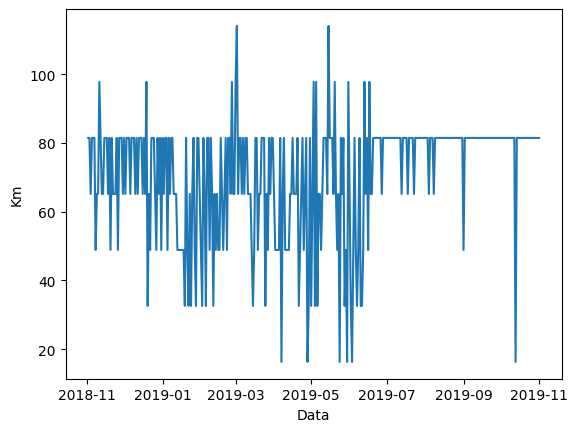

In [180]:
plt.plot(dados)
plt.xlabel('Data')
plt.ylabel('Km')

## Correlações
1. Fazendo Auto-Correlation Function (ACF) plot
2. Fazendo Partial Auto-Correlation Function (PACF) plot
3. Seasonal differencing

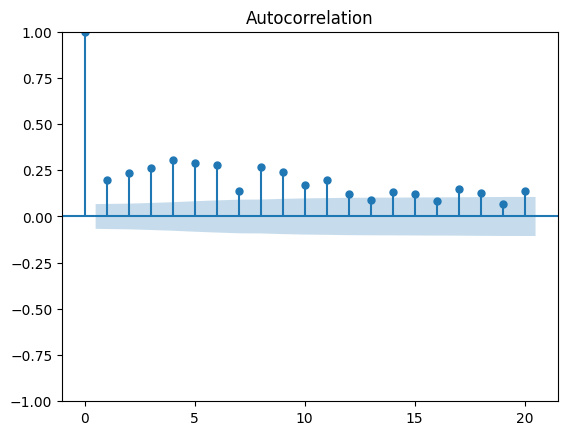

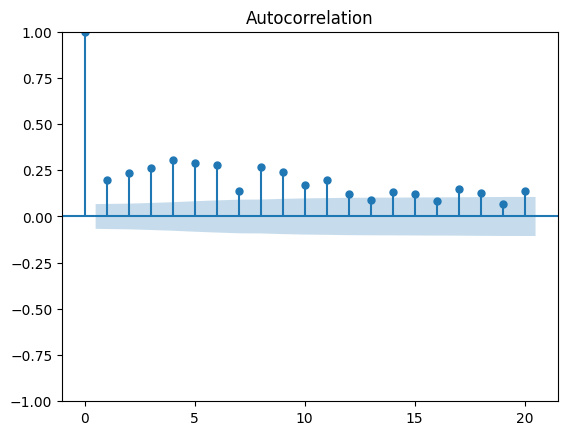

In [181]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dados['KmPercorridos'], lags=20, alpha=0.20)

In [182]:
from statsmodels.tsa.stattools import acf
acf(dados['KmPercorridos'])

array([1.        , 0.19491397, 0.23659659, 0.2623014 , 0.30649668,
       0.29038797, 0.27930459, 0.13575893, 0.2695084 , 0.23993455,
       0.17196164, 0.19856826, 0.12125374, 0.09167988, 0.13084983,
       0.11976645, 0.08606907, 0.14946388, 0.12581716, 0.07021483,
       0.13844222, 0.1063557 , 0.08683251, 0.13766399, 0.13160594,
       0.08856695])

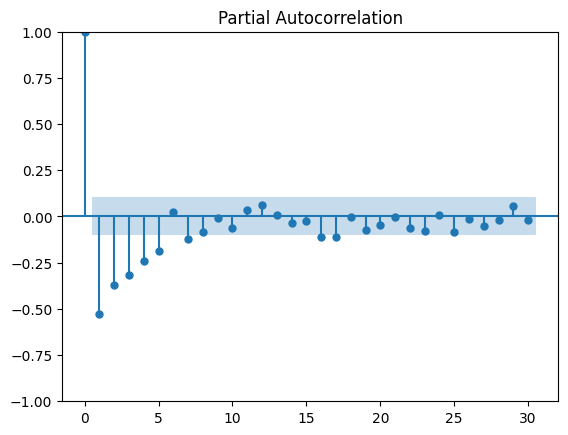

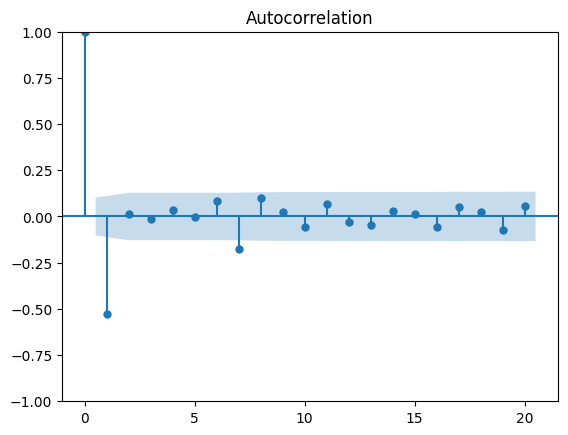

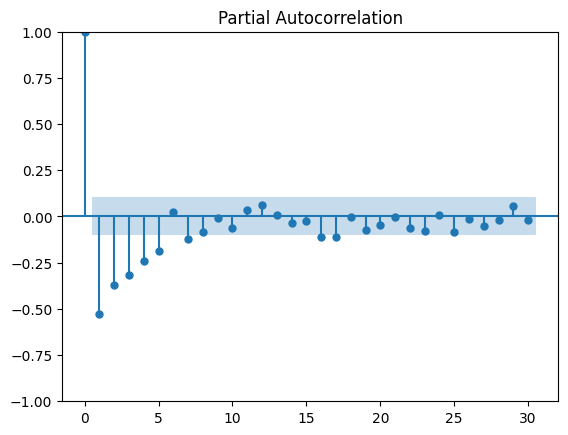

In [183]:
from statsmodels.graphics.tsaplots import plot_pacf

dados_df = dados.diff()
dados_df = dados_df.dropna()

plot_acf(dados_df, lags=20)
plot_pacf(dados_df, lags=30)

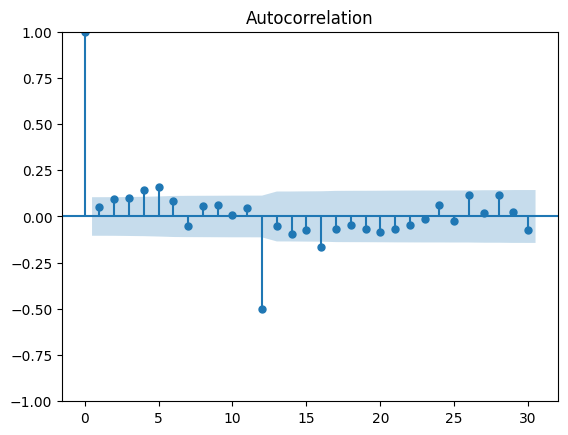

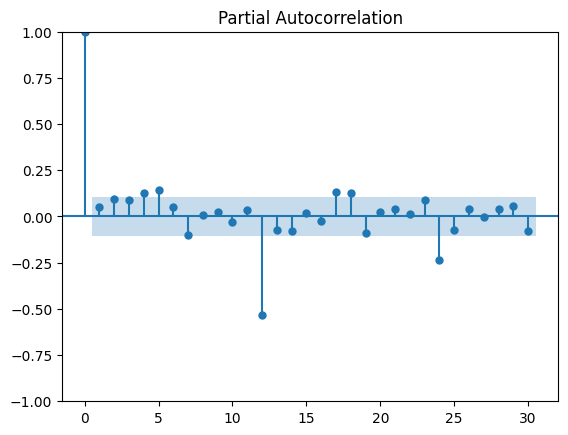

In [184]:
dados_df = dados.diff(12)
dados_df = dados_df.dropna()

plot_acf(dados_df, lags=30)

plot_pacf(dados_df, lags=30)
plt.show()

## Ajustando modelo
1. Arima
2. Sarima

In [185]:
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(dados, order=(1,1,1))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:          KmPercorridos   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1515.518
Date:                Tue, 18 Jul 2023   AIC                           3037.036
Time:                        01:23:11   BIC                           3048.727
Sample:                    11-02-2018   HQIC                          3041.682
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1153      0.052     -2.230      0.026      -0.217      -0.014
ma.L1         -0.8441      0.028    -30.563      0.000      -0.898      -0.790
sigma2       241.0911     12.832     18.789      0.0

In [186]:
import statsmodels.api as sm

results = sm.tsa.statespace.SARIMAX(dados, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      KmPercorridos   No. Observations:                  150
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -500.639
Date:                            Tue, 18 Jul 2023   AIC                           1011.279
Time:                                    01:23:15   BIC                           1025.340
Sample:                                05-03-2019   HQIC                          1016.990
                                     - 09-29-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1968      0.092     -2.134      0.033      -0.378      -0.016
ma.L1         -0.7858      0.054   

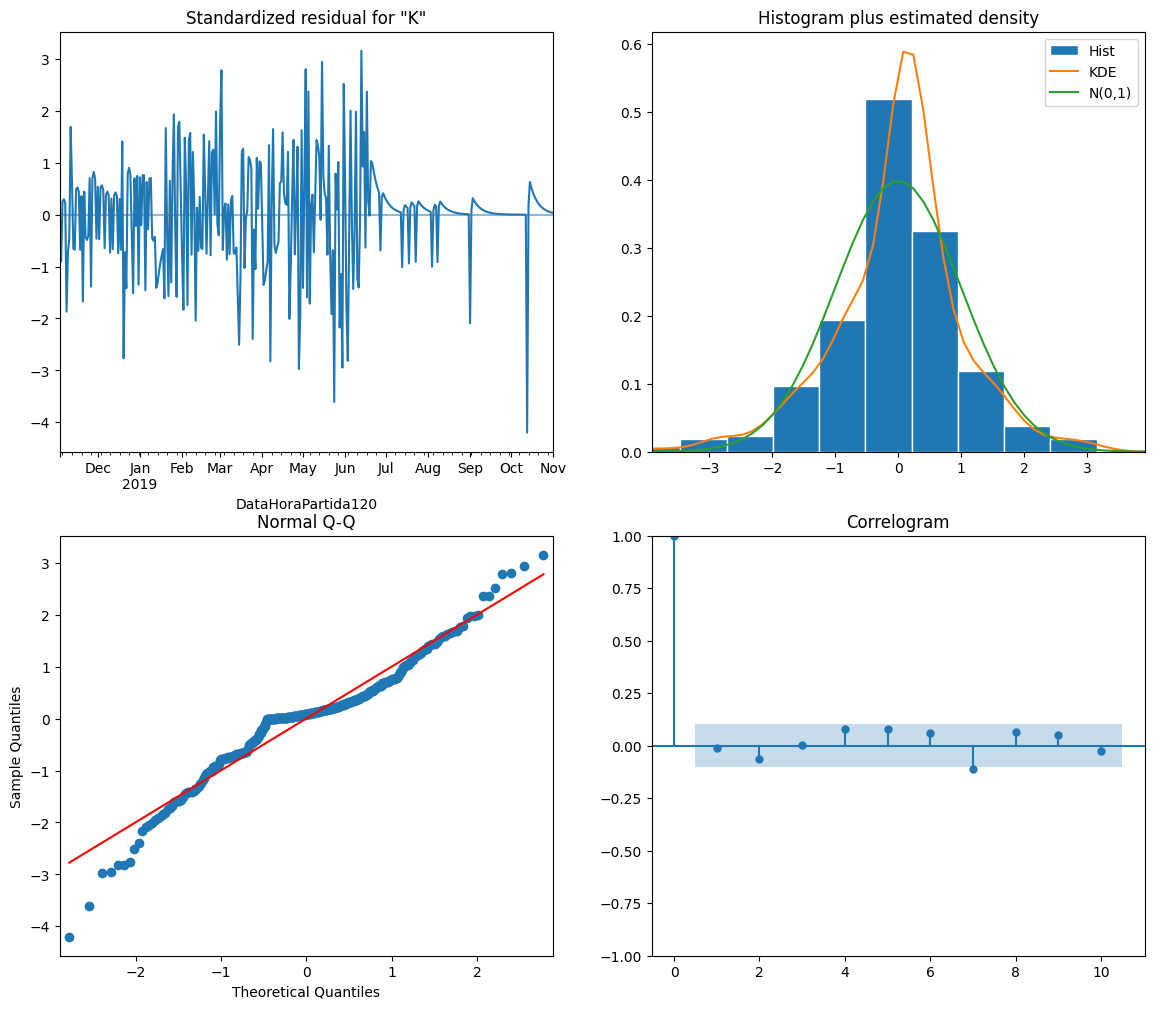

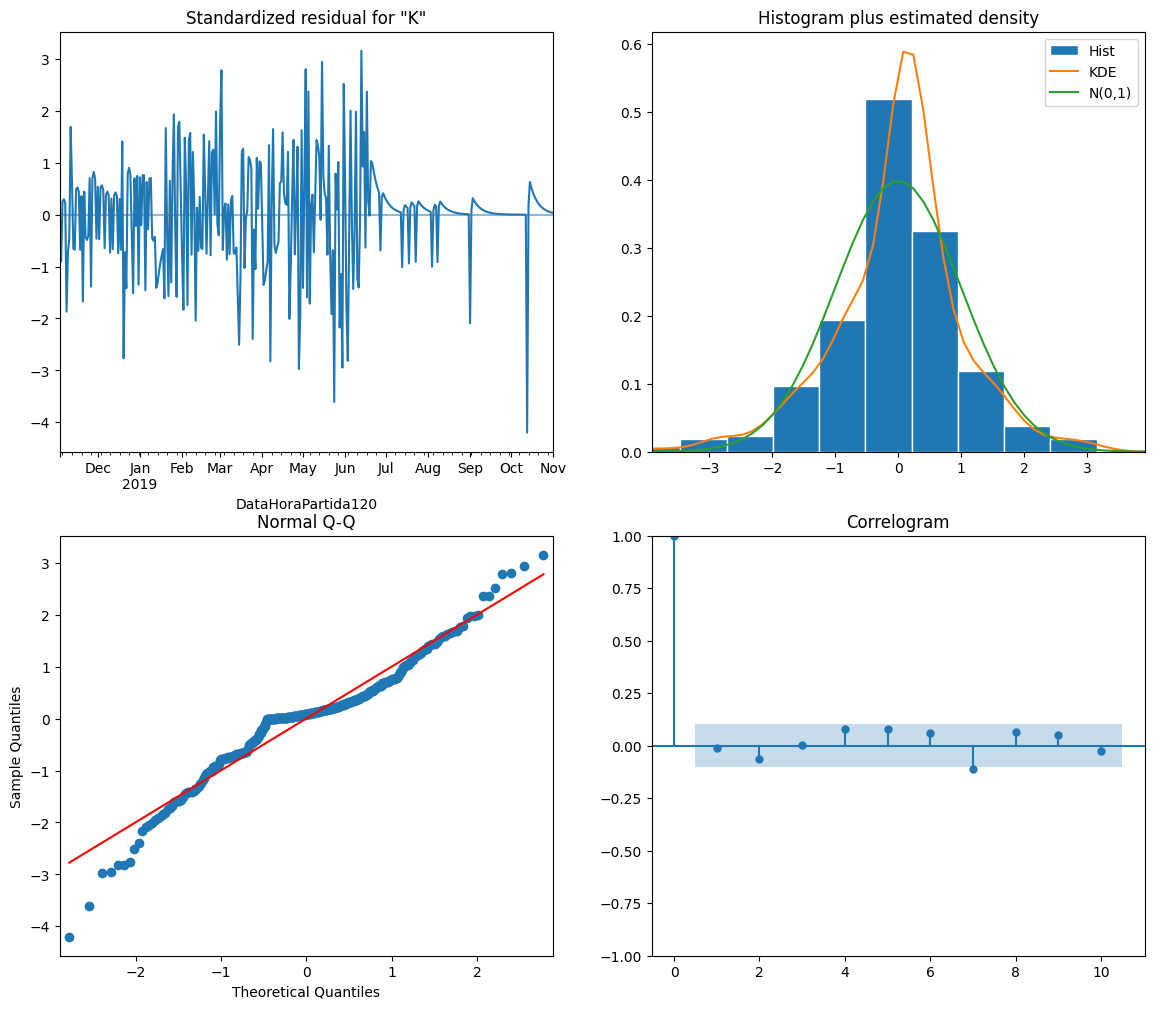

In [187]:
res.plot_diagnostics(figsize=(14,12))

## Realizando predições
1. Para o ARIMA
2. Para o SARIMA

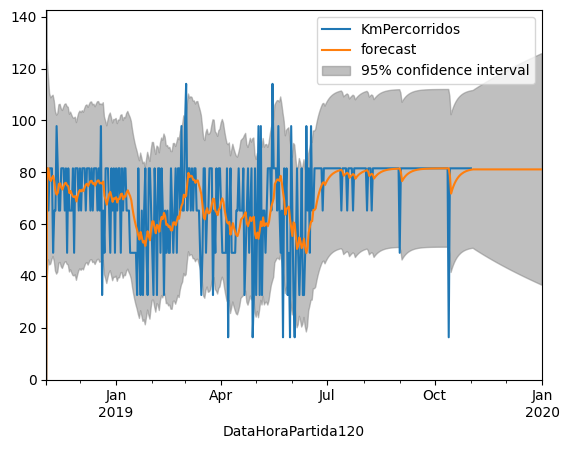

In [188]:
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots()
ax = dados.loc['2018-11-02':'2019-11-01',:].plot(ax=ax)
plt.ylim(0, dados.max()['KmPercorridos'] * 1.25 )
plot_predict(res, '2018-11-02', '2020-01-01', ax=ax)
plt.show()

In [193]:
forecasts = res.forecast(steps=60, alpha=0.05)
forecasts

2019-11-02    81.038061
2019-11-03    81.091338
2019-11-04    81.085194
2019-11-05    81.085903
2019-11-06    81.085821
                ...    
2019-12-27    81.085829
2019-12-28    81.085829
2019-12-29    81.085829
2019-12-30    81.085829
2019-12-31    81.085829
Freq: D, Name: predicted_mean, Length: 60, dtype: float64

In [194]:
# SARIMAX
forecast_values = results.get_forecast(steps=60)
forecast_ci = forecast_values.conf_int()

In [195]:
forecast_values = results.get_forecast(steps=60)
forecast_values.summary_frame()

KmPercorridos,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-09-30,81.960513,13.840336,54.833953,109.087072
2019-10-01,80.392007,13.842331,53.261537,107.522478
2019-10-02,82.156603,14.146295,54.430375,109.882830
2019-10-03,81.148240,14.346750,53.029127,109.267353
2019-10-04,83.286658,14.561841,54.745974,111.827343
...,...,...,...,...
2019-11-24,81.005934,30.723271,20.789430,141.222439
2019-11-25,86.961412,31.050757,26.103046,147.819777
2019-11-26,84.547165,31.375770,23.051786,146.042545
2019-11-27,86.768953,31.697281,24.643425,148.894482


In [196]:
forecast_values.predicted_mean

2019-09-30    81.960513
2019-10-01    80.392007
2019-10-02    82.156603
2019-10-03    81.148240
2019-10-04    83.286658
                ...    
2019-11-24    81.005934
2019-11-25    86.961412
2019-11-26    84.547165
2019-11-27    86.768953
2019-11-28    89.115962
Freq: D, Name: predicted_mean, Length: 60, dtype: float64

In [197]:
forecast_values.conf_int()

,lower KmPercorridos,upper KmPercorridos
2019-09-30,54.833953,109.087072
2019-10-01,53.261537,107.522478
2019-10-02,54.430375,109.882830
2019-10-03,53.029127,109.267353
2019-10-04,54.745974,111.827343
...,...,...
2019-11-24,20.789430,141.222439
2019-11-25,26.103046,147.819777
2019-11-26,23.051786,146.042545
2019-11-27,24.643425,148.894482


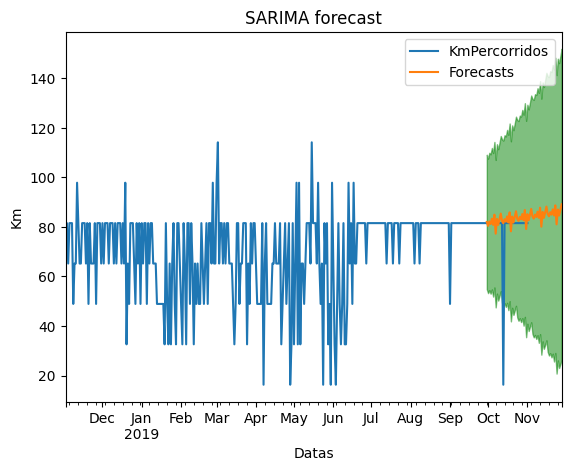

In [198]:
ax = dados.plot()
forecast_values.predicted_mean.plot(ax=ax, label='Forecasts')

ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='g', alpha=0.5)
ax.set_xlabel('Datas')
ax.set_ylabel('Km')
ax.set_title('SARIMA forecast')

plt.legend()

## Métricas e avaliação sem usar cross_validation

In [201]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(np.array(dados['KmPercorridos'])[-60:], np.array(forecasts))
mae = mean_absolute_error(np.array(dados['KmPercorridos'])[-60:], np.array(forecasts))
rmse = mse**.5
print("MSE: ", mse)
print("MAE: ",mae)
print("RMSE: ", rmse)

MSE:  70.12270278028413
MAE:  1.4877455431889584
RMSE:  8.373929948374546


In [202]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(np.array(dados['KmPercorridos'])[-60:], np.array(forecast_values.predicted_mean))
mae = mean_absolute_error(np.array(dados['KmPercorridos'])[-60:], np.array(forecast_values.predicted_mean))
rmse = mse**.5
print("MSE: ", mse)
print("MAE: ",mae)
print("RMSE: ", rmse)

MSE:  92.60650978776046
MAE:  3.949470826135256
RMSE:  9.623227617995974


## Execução do modelo de ARIMA com cross validation
1. Quebrando em 10 pedaços de tamanho máximo de 150 amostras.
2. Realizando o treinamento 

In [166]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from numpy import sqrt 
import statsmodels.api as sm

cross_validation = dados
tscv = TimeSeriesSplit(max_train_size=150 ,n_splits = 10)
arima_rmse = []
arima_mae = []
arima_mse = []
forecasts = []
for train_index, test_index in tscv.split(cross_validation):
    cv_train, cv_test = cross_validation.iloc[train_index], cross_validation.iloc[test_index]
    
    arima = sm.tsa.ARIMA(cv_train, order=(1,1,1)).fit()

    forecasts.append(arima.forecast(steps=40))
    
    predictions = arima.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test.values
    arima_rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    arima_mse.append(mean_squared_error(true_values, predictions))
    arima_mae.append(mean_absolute_error(true_values, predictions))
    
print("RMSE: {}".format(np.mean(arima_rmse)))
print("MAE: {}".format(np.mean(arima_mae)))
print("MSE: {}".format(np.mean(arima_mse)))
# predictions
print(forecasts[-1:])

RMSE: 15.751523889276237
MAE: 11.85181017980052
MSE: 309.75213413070213
[2019-09-30    81.492660
2019-10-01    81.494084
2019-10-02    81.493808
2019-10-03    81.493861
2019-10-04    81.493851
                ...    
2019-11-04    81.493853
2019-11-05    81.493853
2019-11-06    81.493853
2019-11-07    81.493853
2019-11-08    81.493853
Freq: D, Name: predicted_mean, Length: 40, dtype: float64]


## Execução do modelo de SARIMA com cross validation
1. Quebrando em 10 pedaços de tamanho máximo de 150 amostras.
2. Realizando o treinamento 

In [167]:
# import statsmodels.api as sm 

# mod = sm.tsa.statespace.SARIMAX(dados, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
# results = mod.fit()
# print(results.summary())

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

from numpy import sqrt 
import statsmodels.api as sm

cross_validation = dados
tscv = TimeSeriesSplit(max_train_size=150 ,n_splits = 10)
sarima_rmse = []
sarima_mae = []
sarima_mse = []
forecasts = []
for train_index, test_index in tscv.split(cross_validation):
    cv_train, cv_test = cross_validation.iloc[train_index], cross_validation.iloc[test_index]
    
    sarima =  sm.tsa.statespace.SARIMAX(cv_train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)

    forecasts.append(sarima.forecast(steps=40))
    
    predictions = sarima.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test.values
    sarima_rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    sarima_mse.append(mean_squared_error(true_values, predictions))
    sarima_mae.append(mean_absolute_error(true_values, predictions))
    
print("RMSE: {}".format(np.mean(sarima_rmse)))
print("MAE: {}".format(np.mean(sarima_mae)))
print("MSE: {}".format(np.mean(sarima_mse)))
predictions
# print(forecasts[-1:])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE: 17.458222397476455
MAE: 13.631018143495428
MSE: 363.4120089814539


2019-09-30    81.960513
2019-10-01    80.392007
2019-10-02    82.156603
2019-10-03    81.148240
2019-10-04    83.286658
                ...    
2019-10-28    85.167198
2019-10-29    82.688893
2019-10-30    86.784424
2019-10-31    79.124510
2019-11-01    85.079987
Freq: D, Name: predicted_mean, Length: 33, dtype: float64